In [14]:
import numpy as np
import pandas as pd
import datetime as datetime

In [2]:
np.random.seed(30300101)

In [3]:
#Storage of variables used to define the dataset
#Start with policy variables

#4 products, to be defined later
prods = range(4)
prods = [x + 1 for x in prods]
prodsWt = [0.5,0.25,0.2,0.05]

#Evenly distribute business within issue year confines
issYrsStart = 2008
issYrs = range(10)
issYrs = [x + issYrsStart for x in issYrs]
issYrsWt = [1/len(issYrs)] * len(issYrs)

#Randomly distribute business amongst n states
nIssSt = 10
issSt = range(50)
issSt = [x + 1 for x in issSt]
issStWt = [0] * len(issSt)
st = np.random.randint(low=0,high=len(issSt)-1,size=nIssSt).tolist()
rd = np.random.uniform(0,1,nIssSt).tolist()
rd = [x/sum(rd) for x in rd]
for i in range(len(st)):
    issStWt[st[i]] = issStWt[st[i]] + rd[i]

In [37]:
#Next to coverage variables

#Future state utilize product mapping table to enable/disable coverage riders at a product level
#Start with random probability for now and a simple assignment of base/rider types
covCnt = [1,2]
covCntWt = [0.9,0.1]

#Presume all riders are optioned at issue

In [5]:
#Next to person variables

#Randomly distribute ages within an issue age band range
#Will be used to calculate dates of birth
#Currently presume an ALB issue age calculation
age = [0,25,35,45,55,65,75,999]
ageWt = [0,0.05,0.15,0.25,0.3,0.15,0.1,0]

#Two genders within underwriting criteria
sex = range(2) 
sexWt = [0.5,0.5]

#Spousal riders
#Current code presumes no joint life policies, and that lives on coverages match back to base
#Future state may contemplate assigning a different insured on rider records, or joint life policies
lives = [0,1,2]
livesWt = [0,1,0]

#Multiple issues
multiplePol = [0,1,2,3,4,5]
multiplePolWt = [0,0.8,0.1,0.05,0.025,0.025]

In [6]:
#Finally, temporal statistics

#Probability of surrender
lapseDur = [1,2,3,99]
lapseWt = [0.2,0.1,0.05,0.65]
ultLapse = 0.05

In [15]:
#UDFs
def assignLabel(rnd, labelArray,weightArray):
    c = 0
    for i in range(len(weightArray)):
        c = c + weightArray[i]
        if c > rnd:
            x = labelArray[i]
            break
    return x

def rndDate(rnd,start,end):
    fmt = '%Y-%m-%d'
    #st = datetime.strptime(start,fmt).timestamp()
    #ed = datetime.strptime(end,fmt).timestamp()
    st = datetime.datetime.strptime(start,fmt)
    ed = datetime.datetime.strptime(end,fmt)
    dt = st + rnd * (ed - st)
    #dt = datetime.utcfromtimestamp(dt).strftime(fmt)
    dt = datetime.datetime.strftime(dt,fmt)
    return dt

def rndGammaDate(start,shape,scale):
    fmt = '%Y-%m-%d'
    st = datetime.datetime.strptime(start,fmt)
    dt = st + datetime.timedelta(days = np.random.gamma(shape,scale) * 365)
    dt = datetime.datetime.strftime(dt,fmt)
    return dt

In [48]:
#Pattern will be lives -> policies -> coverages -> amounts
#Because of the inherent temporal dependency between lives (birth date, death date) and policies (issue date, lapse date)
nLives = 50000
lifedf = pd.DataFrame(columns=['lifeId','sexId','birthDate','deathDate'])
lifecovdf = pd.DataFrame(columns=['coverageId','lifeId'])
poldf = pd.DataFrame(columns=['policyId','policyNumber','productId','issueDate','issueState'])
covdf = pd.DataFrame(columns=['coverageId','policyId','coverageNo','coverageTypeId','productId','issueDate'])
lifepoldf = pd.DataFrame(columns=['policyId','lifeId'])
lifeIdx = 0
polIdx = 0
covIdx = 0

while lifeIdx < nLives:
    lifeIdx = lifeIdx + 1
    
    sexId = assignLabel(np.random.uniform(0,1),sex,sexWt)
    ageVal = assignLabel(np.random.uniform(0,1),age,ageWt)
    
    #Given a presumed disitribution of issue ages, and the mechanical linkage with issue date and birth date
    #Begin by obtaining a base policy issue date... subsequent issues will register after this date
    baseIssueYr = assignLabel(np.random.uniform(0,1),issYrs,issYrsWt)
    baseIssueDt = rndDate(np.random.uniform(0,1),str(baseIssueYr)+'-01-01',str(baseIssueYr)+'-12-31')
    ageYr = int(str(baseIssueDt)[0:4]) - int(ageVal)
    strDt = str(baseIssueDt)[4:10]
    if strDt == '-02-29':
        strDt = '-03-01'
    birthDt = rndDate(np.random.uniform(0,1),str(ageYr) + strDt,str(ageYr + 1) + strDt)
    
    #Death date occurring after issue rather than distributed from birth date
    deathDt = rndGammaDate(baseIssueDt, 1, 1 / 0.025)
    lifedf.loc[lifeIdx] = [lifeIdx,sexId,birthDt,deathDt]
    
    nPols = assignLabel(np.random.uniform(0,1),multiplePol,multiplePolWt)
    for i in range(nPols):
        polIdx = polIdx + 1
        if i == 0:
            issueDt = baseIssueDt
        else:
            #Subsequent issue has to occurr before death date)
            issueDt = rndDate(np.random.uniform(0,1),baseIssueDt,min(str(max(issYrs))+'-12-31',deathDt))
        polNo = hex(hash(np.random.uniform(0,1)))[0:10]
        prodId = assignLabel(np.random.uniform(0,1),prods,prodsWt)
        issStId = assignLabel(np.random.uniform(0,1),issSt,issStWt)
        poldf.loc[polIdx - 1] = [polIdx,polNo,prodId,issueDt,issStId]
        lifepoldf.loc[polIdx - 1] = [polIdx,lifeIdx]
        nCovs = assignLabel(np.random.uniform(0,1),covCnt,covCntWt)
        termDt = rndGammaDate(issueDt, 1, 1 / 0.1)
        if termDt > deathDt: termDt = deathDt
        for j in range(nCovs):
            covIdx = covIdx + 1
            covNo = hex(hash(np.random.uniform(0,1)))[0:10]
            covProdId = prodId * 10 + j
            covIssueDt = issueDt
            if j == 0: 
                covType = 1
            else:
                covType = 2
            covdf.loc[covIdx - 1] = [covIdx,polIdx,covNo,covType,prodId,issueDt]
            lifecovdf.loc[covIdx - 1] = [covIdx,lifeIdx]
            
poldf.to_csv(r'C:\Users\prove\OneDrive\Desktop\poldf.csv')
lifepoldf.to_csv(r'C:\Users\prove\OneDrive\Desktop\lifepoldf.csv')
covdf.to_csv(r'C:\Users\prove\OneDrive\Desktop\covdf.csv')
lifedf.to_csv(r'C:\Users\prove\OneDrive\Desktop\lifedf.csv')
lifecovdf.to_csv(r'C:\Users\prove\OneDrive\Desktop\livecofdf.csv')

In [40]:
len(poldf)

127

In [164]:
#Temporal backfill

#lapse date
for i in range(len(poldf)):
    rnd = np.random.uniform(0,1)
    lapDur = assignLabel(rnd,lapseDur,lapseWt)
    if lapDur == 99:
        lapDur = int(np.log((1-rnd)/(1-sum(lapseWt[0:len(lapseWt)-1])))/np.log(1-ultLapse)+len(lapseWt)-1)
    lapDt = rndDate(np.random.uniform(0,1),poldf.issueDate[i][0:4]+'-01-01',poldf.issueDate[i][0:4]+'-12-31')
    

(array([21.,  6., 12.,  7.,  4., 11.,  4.,  9., 10., 16.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

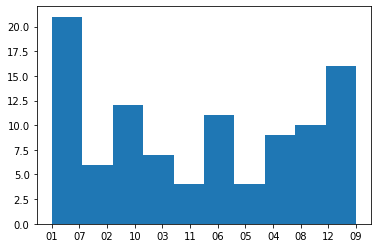

In [298]:
from matplotlib import pyplot as plt
plt.hist([x[5:7] for x in poldf.issueDate[:]])